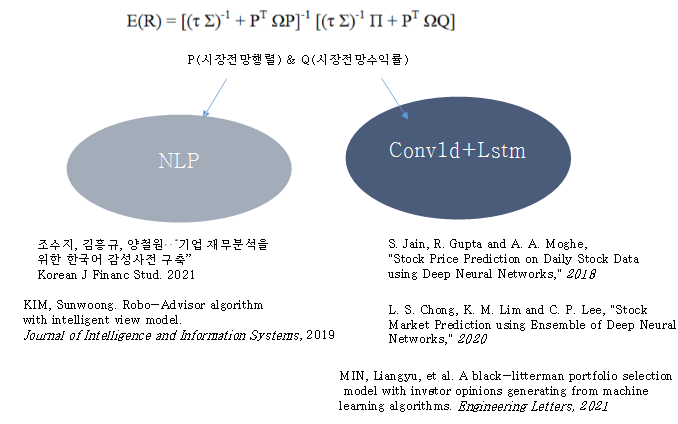

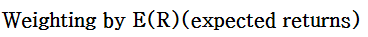

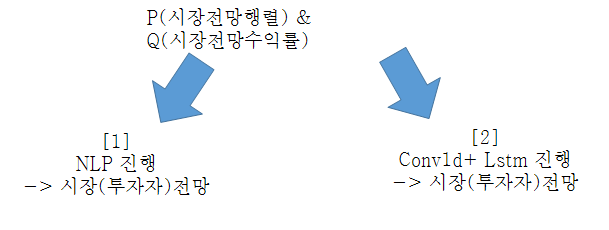

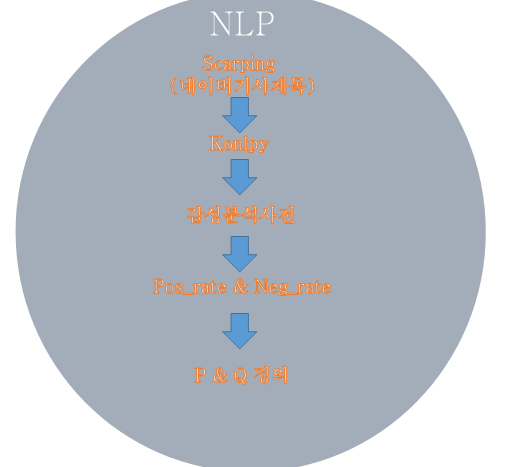

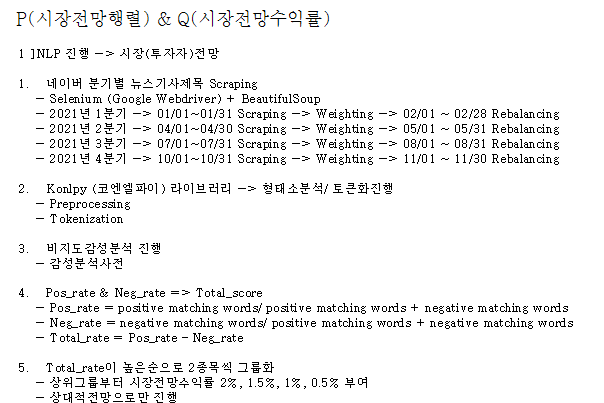





# Webdriver 기반 네이버기사제목 Scraping 

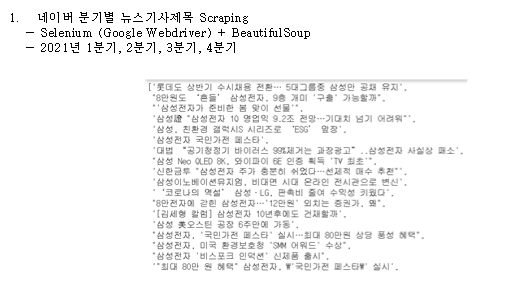

In [ ]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

!pip install bs4 lxml
import bs4
from bs4 import BeautifulSoup

In [ ]:

def get_titles(url='', imp_time=0):

    driver = webdriver.Chrome('chromedriver') # driver객체선언 

    driver.implicitly_wait(imp_time)

    driver.get(url)

    src = driver.page_source
    html = BeautifulSoup(src, 'lxml')

    titles = html.find_all('a', attrs = {"class":'news_tit'})

    for title in titles:
        try:
            content = title.text
            titles_list.append(content)
        except:
            pass
        
    driver.quit()
    
    return titles_list 

In [ ]:
import pandas as pd

#titles_list = []
for i in range(700, 1000):
    url = 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%EC%B9%B4%EC%B9%B4%EC%98%A4&sort=0&photo=0&field=0&pd=3&ds=2021.04.01&de=2021.04.30&cluster_rank=31&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from20210401to20210430,a:all&start='+ str(i) + '1'
    #print(url)
    titles_list_df = get_titles(url, 1)
    
    title_1Q = pd.DataFrame(titles_list_df)
    title_1Q.to_csv('Kakao_title_2Q_1.csv' )

In [ ]:
import pandas as pd


titles_list = pd.read_csv('../input/titles-1q/NAVER_title_1Q_1.csv')['0']
print(titles_list)
print('\n')
print(len(titles_list))

# Preprocessing

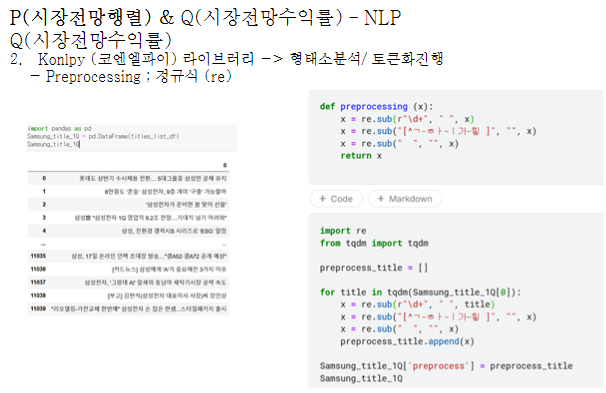

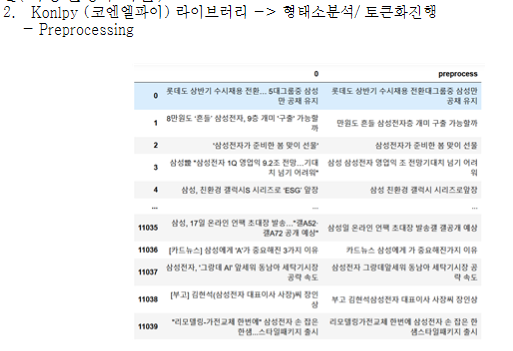



In [ ]:
import re
from tqdm import tqdm 

def preprocessing (x):
    x = re.sub(r"\d+", " ", x)
    x = re.sub(r"[%$^*!]", " ", x)
    x = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)
    x = re.sub("  ", "", x)
    return x 



In [ ]:
preprocess_title = []

for title in tqdm(titles_list):
    x = re.sub(r"\d+", " ", title)
    x = re.sub(r"[%$^*!]", " ", x)
    x = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)
    x = re.sub("  ", "", x)
    preprocess_title.append(x)

titles_list['preprocess'] = preprocess_title
titles_list

# Korean Tokenization 

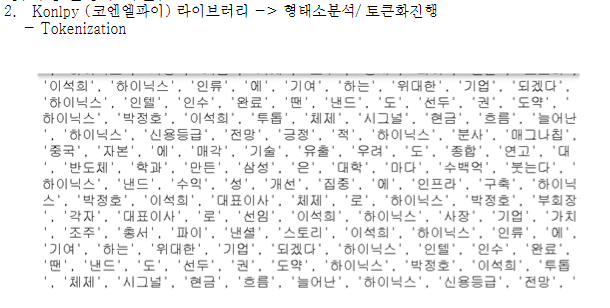



In [ ]:
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
okt = Okt()

import re

# 토크나이저 생성 
def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko


# KoNLPy(tokenizer)로 토큰화진행 (형태소 분석기)



def get_tokens_list(tokens_list=[], df=df):

    for i in range (len(df)):
        tokens_ko = tw_tokenizer(str(df[df.index == i].preprocess.values))
        tokens_list.append(tokens_ko)
    tokens_str = str(tokens_list)
    
    
    x = re.sub(r"\d+", " ", tokens_str)
    x = re.sub(r"[%$^*!]", " ", x)
    x = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)
    tokens_str = re.sub("  ", "", x)
    print(tokens_str)
    tokens_list = tokens_str.split(' ')
    print(tokens_list)
    
    
    return tokens_list
    
    
tokens_list = get_tokens_list(tokens_list=[], df=df_list[0])

# 이후 비지도 감성분석 가능 


# 감성사전 

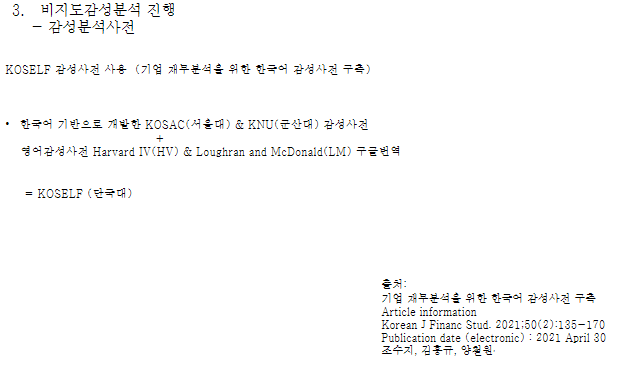

In [ ]:
# 감성 사전 

neg = ['결국, 결함, 공허한, 과적, 극심한, 둔화, 마이너스, 몰수, 우려, 유출, 미완성, 배상, 부적합한, 부정적, 부정적인, 부주의, 불리한, 소란, 스캔들, 실패, 악화, 약점, 약화, 여파, 연기, 우발적, 의심, 의혹, 잘못, 저품질, 저해, 정체, 조치, 주의, 지나친, 지독한, 지연, 질타, 차질, 초라한, 충격, 침체, 투자 회수, 파산, 평가절하, 하락, 해체, 혼란, 훼손']

neg = neg[0].split(',')

neg_dic = [i.replace(' ','') for i in neg]

pos = ['가치, 가치 있는, 강세, 개선, 개선된, 개선되는, 경신, 경의, 고급, 기꺼이, 더 좋은, 도움이 되는, 뛰어나, 명성, 바닥, 본격적인, 상승효과, 상회한, 성공, 수혜, 순조롭게, 실현, 안정된, 완전한, 우세, 우월, 우호적, 심의, 여지가 없는']

pos = pos[0].split(',')

pos_dic = [i.replace(' ','') for i in pos]

print('<부정어 감성사전>')
print(neg_dic)
print('\n')
print('<긍정어 감성사전>')
print(pos_dic)



# Pos_rate, Neg_rate

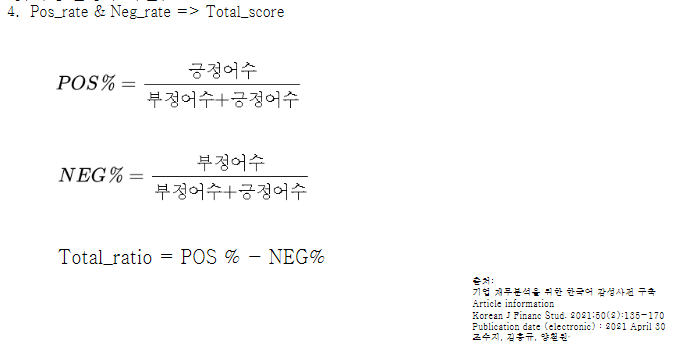

In [ ]:
# 사전 비교 

def get_comparision (tokens_list=[], pos=pos_dic, neg=neg_dic):

    import numpy as np

    N = len(tokens_list)

    res = np.zeros(shape=(N,2), dtype= np.int64)


    for i in range(N):
        t = tokens_list[i]
        cnt = 0

        for j in range(len(pos)):
            p = pos[j]

            if t == p: 
                cnt += 1
            else:
                pass

        res[i, 1] = cnt

    for i in range(N):
        t = tokens_list[i]
        cnt = 0

        for j in range(len(neg)):
            n = neg[j]

            if t == n: 
                cnt += 1
            else:
                pass

        res[i, 0] = cnt


    return res


#Samsung_1Q_res = get_comparision (tokens_list=Samsung_1Q_tokens_list, pos=pos_dic, neg=neg_dic)

In [ ]:
def get_pos_rate (res=_, tokens_list= _):

    pos_rate = sum(res[:, 1]) / (sum(res[:, 1])+sum(res[:, 0]))
    neg_rate = sum(res[:, 0]) / (sum(res[:, 1])+sum(res[:, 0]))
    total_rate = pos_rate - neg_rate
    print('총 단어개수:', len(tokens_list) )
    print('pos matching 단어개수:', sum(res[:, 1]))
    print('neg matching 단어개수:', sum(res[:, 0]))
    print('positive rate:', pos_rate)
    print('negative rate:', neg_rate)
    print('total rate:', total_rate)
    
    return pos_rate, neg_rate, total_rate  

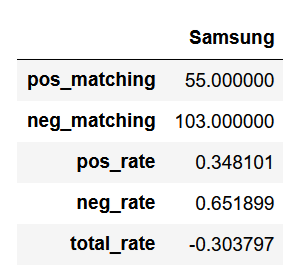

# Total_Rate이 높은 종목부터 2종목씩 그룹화 

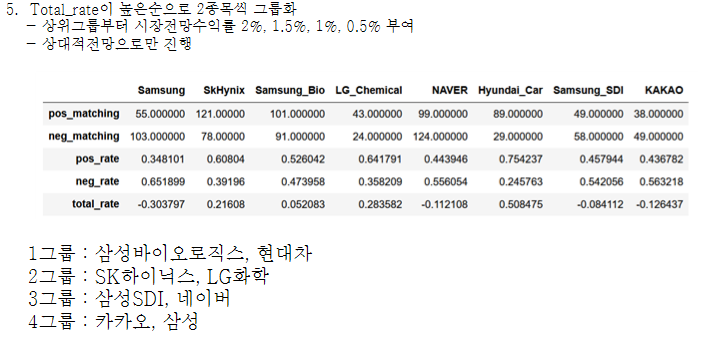

In [ ]:
stock_names = ['Samsung', 'SkHynix', 'Samsung Bio', 'LG Chemical', 'NAVER', 'Hyundai Car', 'Samsung SDI', 'KAKAO' ]


P = np.array([[-0.25, 1-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, 1-0.25],
                  [-0.25, -0.25, -0.25, 1-0.25, -0.25, -0.25, 1-0.25, -0.25],
                  [1-0.25, -0.25, 1-0.25, -0.25, -0.25, -0.25, -0.25, -0.25],
                  [-0.25, -0.25, -0.25, -0.25, 1-0.25, 1-0.25, -0.25, -0.25]])